In [1]:
import geopandas as gpd
import glob
from shapely.ops import transform
import pygmt
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
from shapely.ops import transform

In [2]:
import re

# Optimized function that extracts the age and sorts the file paths
def sort_files_by_age(fpaths, match_string='Ma'):
    """
    This function extracts ages from file paths and sorts them chronologically.

    Parameters:
    fpaths: list of file paths
    match_string: the string to match before the age (default is 'Ma')

    Returns:
    Dictionary with the extracted age as the key and the sorted file paths as values
    """
    # Use a generator to extract ages and pair them with file paths
    def extract_age(file_name):
        match = re.search(f'{match_string}(\d+).', file_name)
        return int(match.group(1)) if match else float('inf')  # return inf if no match is found

    # Sort the file paths by the extracted age using a generator expression
    sorted_files = sorted(fpaths, key=lambda x: extract_age(x))
    
    # Return a dictionary with the age as the key and the file path as the value
    return {extract_age(file): file for file in sorted_files}

In [3]:
def filepath_to_nc(fpaths):
    """
    This function takes nc file fpaths and returns a single nc file stacked over age/time dimension

    Parameters:
    fpath: list of filepaths locating nc file for gld models spaced [X] Ma simulations
    
    Returns:
    single ncfile with stacked time dimension
    """
    #nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items()]  # original
    #added on 05 June 2025 to select DT on 20 Myr gaps
    nc_files = [xr.open_dataset(value).assign(age=[key]) for key, value in fpaths.items()]
    ncfiles = xr.concat(nc_files, dim='age')
    if 'lon' in ncfiles.dims:
        ncfiles=ncfiles
    else:
        ncfiles = ncfiles.rename({'x':'lon', 'y':'lat'})
    return ncfiles

/Users/sd277/Library/CloudStorage/OneDrive-UniversityofWollongong/Final_Scripts_and_Figures/DTvsSediment
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent LAU : Total area = 19.66 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent AMZ : Total area = 12.90 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent AUS : Total area = 6.10 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent EAS : Total area = 36.50 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent AFR : Total area = 28.07 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent NCC : Total area = 2.62 million km²
['.././orogens/ne_110m_land/ne_110m_land.shp']
Continent BAL : Total area = 7.52 million km²


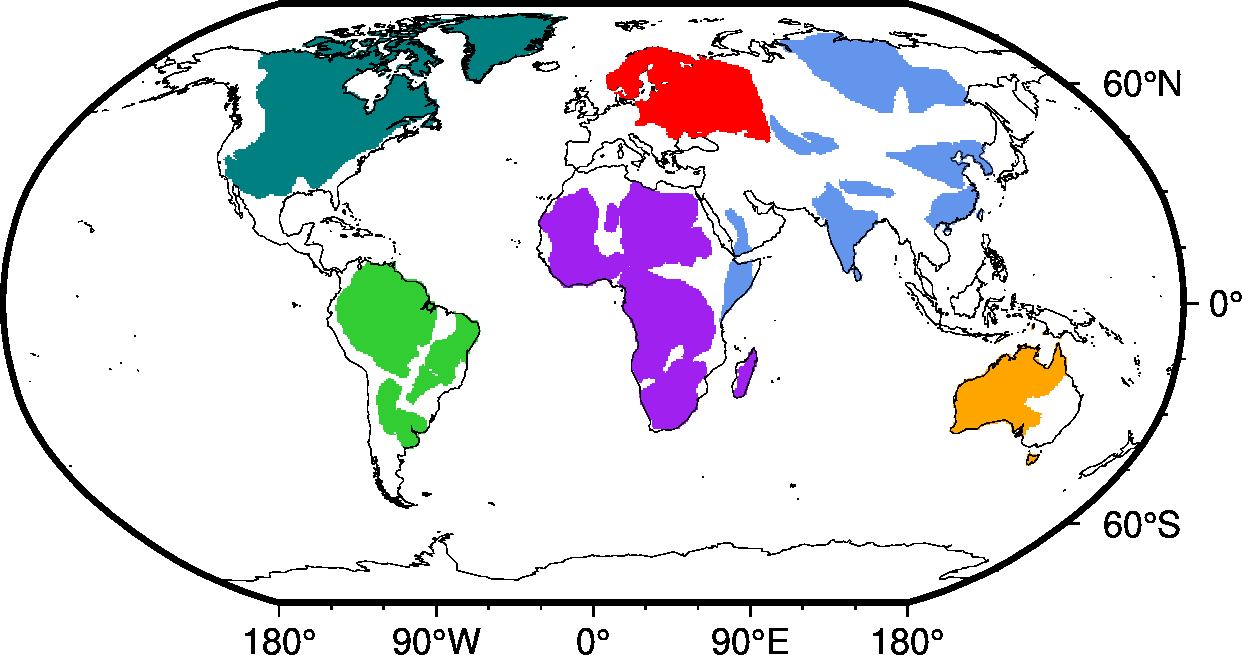

In [5]:
import os
import xarray as xr
print(os.getcwd())
import numpy as np

model ='gld504'
continent_names= [ 'LAU','AMZ','AUS', 'EAS', 'AFR', 'NCC', 'BAL' ]
# continents = ["North America",  "South America", "Australia", "Eurasia", "Africa"]
# continent_keys = [ "Ronov_NAm",  "Ronov_SAm", "Ronov_Aus", "Ronov_Eur", "Ronov_Afr"]
colors = [ '#008080', '#32CD32', 'orange',  '#6495ED', 'purple', '#6495ED', 'red']
#colors =['green','blue', 'red','cyan', 'brown']
# pd.DataFrame(continents_dt)
fig1 = pygmt.Figure()
region='d'
projection ='N10c'

for i, (continent, color) in  enumerate(zip(continent_names, colors)):  
    
   
    if continent not in ['NCC', 'BAL']:
        DT_files = glob.glob(f'./{model}/PlateFrameGrid_{continent}/*.nc')
    else:
        DT_files = glob.glob(f'../../Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
    sorted_DT_files = sort_files_by_age(DT_files, match_string='Grid')
    DT_nc = filepath_to_nc(sorted_DT_files)
    

    #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
    DT_nc = DT_nc.sel(age = slice(0,920))
    mask_920 = DT_nc.sel(age=920)
    DT_nc = DT_nc.where(mask_920)
    DT_nc['c'] = DT_nc['z'] * 0 + 100

    
    land_mask_file = glob.glob('.././orogens/ne*/*.shp')
    print(land_mask_file)
    land_mask = gpd.read_file(land_mask_file[0])
    DT_nc=DT_nc.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
    land_masked_dataset=DT_nc.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)

    # Suppose variables are 'lat' and 'lon'
    area_var =land_masked_dataset.sel(age=540)
    lat = area_var['y'].values
    lon = area_var['x'].values
    
    # Assume uniform spacing
    dlat = np.deg2rad(lat[1] - lat[0])
    dlon = np.deg2rad(lon[1] - lon[0])
    
    # Earth radius (m)
    R = 6_371_000
    
    # Compute area (m²) per latitude band
    # A = R^2 * Δλ * Δφ * cos(φ)
    area_per_lat = (R**2) * dlat * dlon * np.cos(np.deg2rad(lat))
    
    # Expand to 2D grid (lat × lon)
    area_grid = np.outer(area_per_lat, np.ones(len(lon)))
    
    # Example: mask a region or pixel group
    
    mask =  (area_var.c > 0.5) & (~np.isnan(area_var.c))  # e.g., threshold or region
    
    # Total area of that group
    total_area_m2 = np.sum(area_grid[mask])
    total_area_km2 = total_area_m2 / 1e6
    
    print(f"Continent {continent} : Total area = {total_area_km2 /1e6 :.2f} million km²")


    fig1.coast(region=region, projection=projection, shorelines="1/0.1p,black")
    pygmt.makecpt(cmap=color, series=[0,100] )
    fig1.grdimage(grid=land_masked_dataset.sel(age=920).c, projection=projection, region= region, nan_transparent="+znan", cmap=True , frame=False)
    fig1.basemap(region=region, projection =projection, frame=['ltSE', 'xaf', 'yaf'])
    
    #fig.legend()
fig1.show()

### Extract DT evolution for each continental block to Ronov's time step

In [7]:
import pygmt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic

model ='gld504'
continent_names= [ 'LAU','AMZ','AFR','AUS', 'EAS']
additional_continents = ['SIB', 'CON', 'KAL','WAC','BAL', 'NA', 'NCC']
colors =['forestgreen','blue', 'red','cyan', 'brown']



ronov_fpath=glob.glob('*.xls')[0]
 #Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

#ronov = resample_custom_intervals(ronov)

#---------------------------- Extract data to Ronov's Df--------------------------------------#
def extract_DT_to_ronov_steps(ronov_fpath, continent_names, model, continent_type ='main'):

   
    
    continents_dt ={}
    for continent in continent_names:
        #print(continent)
        
        if continent_type =='main':
            continental_DT_files = glob.glob(f'./{model}/PlateFrameGrid_{continent}/*.nc')
        else:
            continental_DT_files = glob.glob(f'../../Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
        
        sorted_DT_files = sort_files_by_age(continental_DT_files, match_string='Grid')
        
        DT_nc = filepath_to_nc(sorted_DT_files)
        
    
        #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
        DT_nc = DT_nc.sel(age = slice(0,920))
        mask_920 = DT_nc.sel(age=920)
        DT_nc = DT_nc.where(mask_920)
        
        # Congo, Kalahari, WAC, Siberia and Baltica
    
        
    
        # -----------------------nc to spatially averaged dataframe------------------------#
        df = DT_nc.mean(dim=['lon','lat']).z.to_dataframe().reset_index()
    
        # Define a function that extracts, averages by interval
        def extract_average_by_interval(data_df, intervals_df,  tolerance=0):
            results = []
            for i, row in intervals_df.iterrows():
                low, high = row['t_age'] - tolerance, row['b_age'] + tolerance
                subset = data_df[(data_df['age'] >= low) & (data_df['age'] <= high)]
                
                if not subset.empty:
                    avg_val = subset['z'].mean()
                else:
                    # fallback: find nearest available age
                    target_age = (low + high) / 2  # midpoint of interval
                    nearest_idx = (data_df['age'] - target_age).abs().idxmin()
                    avg_val = data_df.loc[nearest_idx, 'z']
                
                results.append({
                    'b_age': row['b_age'],
                    't_age': row['t_age'],
                    continent: avg_val
                })
            
            return pd.DataFrame(results)
        
        # Example usage
        averaged_df = extract_average_by_interval(df, ronov, tolerance=1)
        continents_dt[continent] = averaged_df
  
    stepped_continental_DTs= pd.concat(continents_dt.values(), axis=1)#.drop(['age', 'interval'], axis=1)
    stepped_continental_DTs = stepped_continental_DTs.loc[:, ~stepped_continental_DTs.columns.duplicated()]
    # stepped_continental_DTs['b_age'] = ronov['b_age']
    # stepped_continental_DTs['t_age'] = ronov['t_age']
    return stepped_continental_DTs

stepped_continental_DT = extract_DT_to_ronov_steps(ronov, continent_names, model, continent_type ='main')
#print(stepped_continental_DT)
BaSiC_KaWA = extract_DT_to_ronov_steps(ronov, additional_continents, model, continent_type ='additional')
#print(BaSiC_KaWA, stepped_continental_DT)

/Users/sd277/Library/CloudStorage/OneDrive-UniversityofWollongong/Final_Scripts_and_Figures/DTvsSediment
North America


ValueError: must supply at least one object to concatenate

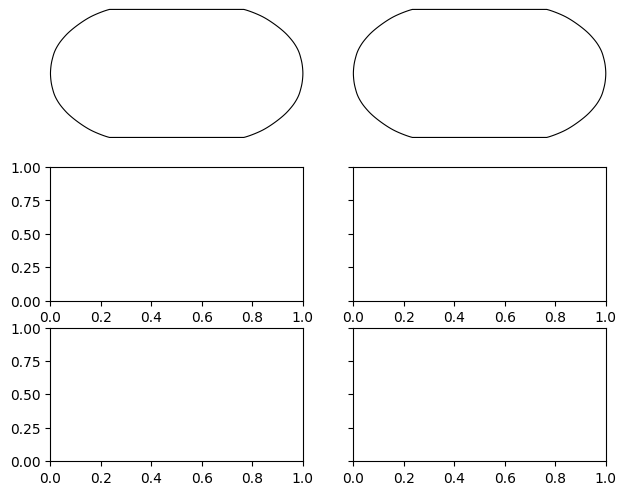

In [13]:
import os
import xarray as xr
print(os.getcwd())
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib import cm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

# import pygmt
# import glob

# Matplotlib
incm = 1 / 2.54

model ='gld504'
continent_names= [ 'LAU', 'EAS',  'NCC', 'BAL', 'SIB', 'KAL',  'CON','WAC', ]
# continents = ["North America",  "South America", "Australia", "Eurasia", "Africa"]
# continent_keys = [ "Ronov_NAm",  "Ronov_SAm", "Ronov_Aus", "Ronov_Eur", "Ronov_Afr"]
colors = [ 'teal',   '#6495ED',  'violet', '#7B5EC6','blue', 'orange','brown', 'red']

#colors =['green','blue', 'red','cyan', 'brown']
# pd.DataFrame(continents_dt)




n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


#---------------------------------- Colored age axes corresponding to geological period--------------------------------#
age_intervals = [
    ("Neoproterozoic", 1000, 541, "#fc8d59"),
    ("Cambrian", 541, 485, "#91cf60"),
    ("Ordovician", 485, 444, "#1a9850"),
    ("Silurian", 444, 419, "#67a9cf"),
    ("Devonian", 419, 359, "#3690c0"),
    ("Carboniferous", 359, 299, "#0571b0"),
    ("Permian", 299, 252, "#fdae61"),
    ("Mesozoic", 252, 66, "#fee08b"),
    ("Cenozoic", 66, 0, "#ffffbf"),
]

ronov_fpath=glob.glob('*.xls')[0]
#Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values_org(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    # reverse order accumulation (like Julia)
    for i, key in enumerate(continent_keys):
        
        total = np.zeros(len(x))
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values / dt /contarea[i] *1e8)  # (contarea[i])area averaged continental sediments (km3/yr/km2) [::-1] reverses the order as reversed for continents
        vol_cumulative[:, i] = total
        #print(f'{key}:{ronov[key].head()}: {vol_cumulative}')
    return total, vol_cumulative

# Compute Neoproterozoic and  Phanerozoic mean

# --- Compute mean flux in given intervals ---
def compute_mean_flux(x, flux):
    """
    Compute mean flux for Neoproterozoic (1000–541 Ma)
    and Phanerozoic (541–0 Ma).
    """
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)

    neo_mean = np.nanmean(flux[neo_mask])
    phan_mean = np.nanmean(flux[phan_mask])
    return neo_mean, phan_mean


# --- Plot each continent by itself ---
continents = ["North America", 'EAS', "Africa"]
continent_keys = [ "Ronov_NAm", "Ronov_Eur", "Ronov_Afr"]
continentcolors = [ 'teal',  'cornflowerblue', 'purple']
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = [  "LAU", "EAS", "AFR"]
contarea = [24.228E6,  53.4E6, 30.3E6]




# ------------------- Main plotting loop ------------------- #
fig, axes = plt.subplots(3, 2,
    figsize=(18.2*incm, 15*incm),
    sharey=True
)

axes= axes.ravel()

fig.delaxes(axes[0])   # remove the normal axes at 0th index
fig.delaxes(axes[1])    # remove the normal axes index 1

# add geoaxes in its place
geo_ax1= fig.add_subplot(3, 2, 1, projection= ccrs.Robinson())   # row, col, index
geo_ax2= fig.add_subplot(3, 2, 2, projection= ccrs.Robinson())

for k, geo_ax in enumerate([geo_ax1, geo_ax2]):

    if k ==0:
        continent_names = continents
        colors =continentcolors
    else:
        continent_names=continent_names
        colors= colors
    #--------------------Continent sepcific Color Plots-------------------#
    for j, (continent, color) in enumerate(zip(continent_names, colors)):
        print(continent)
        
       
        if continent not in ['NCC', 'BAL', 'SIB', 'KAL', 'WAC', 'CON']:
            DT_files = glob.glob(f'./{model}/PlateFrameGrid_{continent}/*.nc')
        else:
            DT_files = glob.glob(f'../../Model_data/{model}/PlateFrameGrid_{continent}/*.nc')
            print(os.getcwd())
        sorted_DT_files = sort_files_by_age(DT_files, match_string='Grid')
        DT_nc = filepath_to_nc(sorted_DT_files)
        
    
        #-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
        DT_nc = DT_nc.sel(age = slice(0,920))
        mask_920 = DT_nc.sel(age=920)
        DT_nc = DT_nc.where(mask_920)
        DT_nc['c'] = DT_nc['z'] * 0 + 100
    
        
        land_mask_file = glob.glob('.././orogens/ne*/*.shp')
        # print(land_mask_file)
        land_mask = gpd.read_file(land_mask_file[0])
        DT_nc=DT_nc.rio.write_crs("epsg:4326", inplace=True).rename({'lon':'x', 'lat':'y'})
        land_masked_dataset=DT_nc.rio.clip(geometries=land_mask.geometry, crs=4326, all_touched=True)
    
        # Select 920 Ma slice
        c_920 = land_masked_dataset.sel(age=920)['c']
    
        # ---------------- Plotting ---------------- #
        # Use .plot.pcolormesh for raster
        cmap= ListedColormap([color])
        c_920.plot.pcolormesh( cmap=cmap, transform=ccrs.PlateCarree(),add_colorbar=False, ax=geo_ax)

    # Coastlines and decorations

    
    geo_ax.coastlines(linewidth=0.5, color='black')
    geo_ax.set_global()  # or ax.set_extent(region, crs=ccrs.PlateCarree())
    # geo_ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5)
    # Create gridlines and turn off labels on top/right
    gl = geo_ax.gridlines(draw_labels=True, linewidth=0.1, color='gray', alpha=0.5,)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 6, 'color': 'black'}
    gl.ylabel_style = {'size': 6, 'color': 'black'}
    geo_ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
    geo_ax.set_title(' ')
    geo_ax.text(-0.035, 1.095, 'a', transform=geo_ax.transAxes,
                fontsize=8, fontweight='bold', va='top', ha='right')
            


    #--------------DT AND SEDIMENT PLOT----------------__________#

# #labels
fig_labels =['a','b','c','d','e','f']

# fig, axes = plt.subplots(5, 1, figsize=(8*incm,19*incm), sharex=True)



total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)

total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)
print(len(x_ronov),len(vol_cumulative_ronov[:,0]), len(vol_cumulative_DT))

for i, ax in enumerate(axes):
    print(i)
    if i ==geo_index:
        ax.tick_params(top=False, right=False, labeltop=False, labelright=False)
        
        continue
        
    else:
        ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
        ax.fill_between(x_ronov, vol_cumulative_ronov[:, i-1], step="mid", label=continents[i-1], color=continentcolors[i-1], alpha=0.7)
        
        ax1=ax.twinx()
        ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_continent_keys[i-1]].values), color='lightgrey', alpha=0.7)
        #legend
        ax.legend(loc='upper left', frameon=False, facecolor="None", fontsize=6)
        
        ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
        ax.set_xlim(0, 900)

        ax1.set_ylim(-1200, 1200)
        # using a ScalarFormatter
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
        
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(0, 7) 

        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
        #plot additional continental stepped DT
        if i==3:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='orange', alpha=0.7, linestyle='--', linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='red', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.legend(loc="lower right", frameon=False, facecolor="None", fontsize=6)
        #     pass
            
            ax.set_ylabel('')

        if i==2:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='blue', alpha=0.7, linestyle='--',linewidth=0.5)
            
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
            ax1.tick_params(axis='y', right=True, labelright=False)
            ax1.set_ylabel('')
        elif i==1:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='green', alpha=0.7, linestyle='-',linewidth=1.25)
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
            ax.tick_params(axis='x', bottom=True, labelbottom=False)
            ax.tick_params(axis='y',left=True, labelleft=True)
            ax.set_ylabel(' ')
            
            

        # ticks fontsize
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax1.tick_params(axis='both', which='major', labelsize=6)
        
        
        ax1.set_ylim(-1300, 1300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        #ax.set_title(continents[i])
        if i >=2:
            ax.set_xlabel('Age [Ma]', fontsize=6)
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
        if i !=2:
            ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)


        def meters_to_km(x, pos):
            return f"{x/1000:.1f}"  # divide by 1000 to get km
               
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
        #ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3)) 
        ax1.spines["right"].set_color("grey")
        ax.text(-0.035, 1.095, fig_labels[i], transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(wspace=0.075, hspace=0.15)
#plt.savefig('./SedimentvsDT_M6_model_continental_blocks.png', dpi=600, bbox_inches='tight')
plt.show()


/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_20287/1043756394.py:9: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  (gpml_cts[
/var/folders/5l/4gfdgm4927n2gx3mj9g81_4r0000gs/T/ipykernel_20287/1043756394.py:30: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


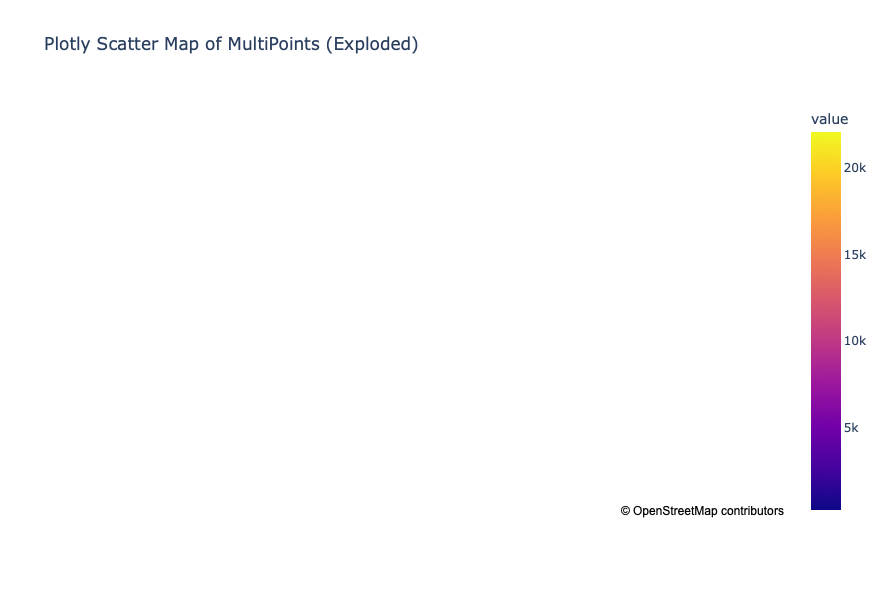

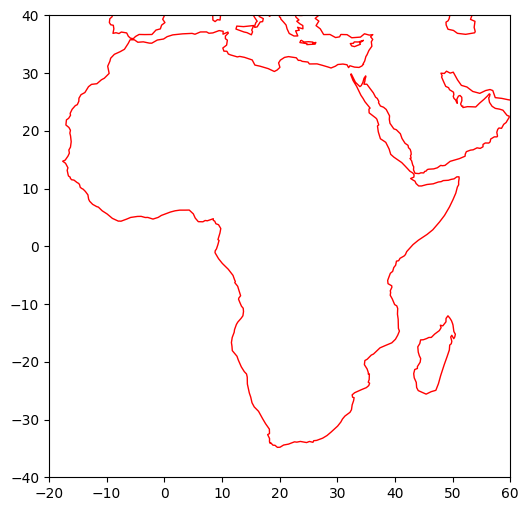

In [5]:
import plotly.express as px
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(1,1, figsize=(10,6))
gpml_cts =gpd.read_file(f'.././Reconstructions/For_gld504/lat_lon_velocity_domain_720_1440_with_plate_IDs_with_ages_for_gld504.gpml')
gpml_cts = gpml_cts[gpml_cts.value.astype(str).str.startswith('2')]
gpml_cts['timePosition'] = gpml_cts['timePosition'].astype(int)
gpml_cts = gpml_cts[gpml_cts.timePosition>=900]
gpml_cts.geometry = gpml_cts.geometry.map(lambda geom: transform(lambda x, y: (y, x), geom))
(gpml_cts[
 (gpml_cts.value.astype(str).str.startswith('7703')) | 
 (gpml_cts.value.astype(str).str.startswith('715')) | 
 (gpml_cts.value.astype(str).str.startswith('714')) | 
 (gpml_cts.value.astype(str).str.startswith('76')) |
 (gpml_cts.value.astype(str).str.startswith('77144')) |
 (gpml_cts.value.astype(str).str.startswith('77141')) 
 
 ].plot(ax=ax1)
)#


# You can update traces to enable clustering, for example:
# fig.update_traces(cluster=dict(enabled=True)) 


#gpml_cts[(gpml_cts.value.astype(str).str.startswith('6'))].plot(ax=ax1, facecolor='cyan')
land_mask.plot(ax= ax1, facecolor="None", edgecolor='red')
plt.xlim(-20, 60)
plt.ylim(-40, 40)
np.unique(gpml_cts.value)
fig.show()
#gpml_cts[gpml_cts.value.astype(str).str.startswith('7')]

exploded_gdf = gpml_cts.explode(index_parts=False).reset_index(drop=True)

#%matplotlib inline
fig_px=px.scatter_map(
    exploded_gdf,
    lat=exploded_gdf.geometry.y,
    lon=exploded_gdf.geometry.x,
    color="value",         # Color points based on their original group name,      # Size points based on a value from the original row
    hover_name="value",    # Show name on hover
    title="Plotly Scatter Map of MultiPoints (Exploded)",
    map_style="open-street-map", # Use a tile map style
    width=1000, 
    height=600,
    zoom=2
)
fig_px.show()

In [10]:
import pandas as pd

def resample_custom_intervals(df):
    """
    Resample intervals into fixed custom bins, aggregating numeric columns
    for rows whose intervals overlap each custom bin.

    Assumes: t_age < b_age (top is younger than bottom).
    """

    custom_bins = [
        (5.933, 145),
        (145, 237),
        (237, 323.3),
        (323.3, 419),
        (419, 541),
        (541, 635),
        (635, 1000),
    ]

    df = df.copy()

    # Check columns exist
    for col in ['t_age', 'b_age']:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found. Available columns: {df.columns.tolist()}")

    results = []

    # Numeric columns to aggregate
    numeric_cols = df.select_dtypes("number").columns.difference(['t_age', 'b_age'])

    for low, high in custom_bins:
        # For t_age < b_age, interval overlaps if:
        # b_age >= low AND t_age <= high
        mask = (df['b_age'] >= low) & (df['t_age'] <= high)

        if mask.any():
            subset = df[mask]
            agg_values = subset[numeric_cols].sum()
            # Keep the youngest t_age and oldest b_age within the overlapping interval
            t_age_resampled = subset['t_age'].min()  # youngest (top)
            b_age_resampled = subset['b_age'].max()  # oldest (bottom)

            results.append({
                "bin": f"{low:.3f}-{high:.3f} Ma",
                "t_age": t_age_resampled,
                "b_age": b_age_resampled,
                **agg_values.to_dict()
            })

    df_resampled = pd.DataFrame(results)
    return df_resampled


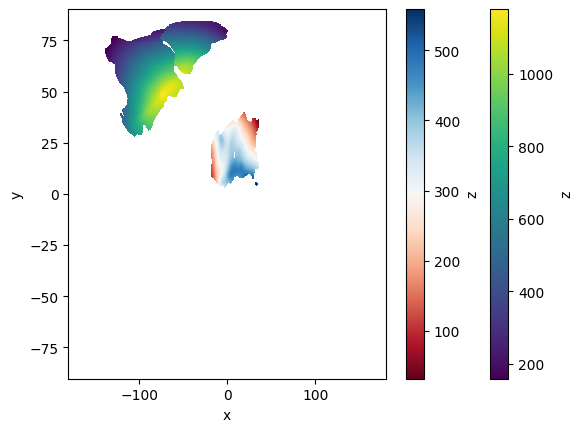

In [26]:
#test difference between Laurentia and North America
xr.open_dataset('./gld504/PlateFrameGrid_LAU/gld504PlateFrameGrid615.nc').z.plot()
xr.open_dataset(f'../Model_data/gld504/PlateFrameGrid_WAC/gld504PlateFrameGrid165.nc').z.plot(cmap='RdBu')


In [ ]:
x = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



# --- Plot each continent by itself ---
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

fig, (ax, ax1) = plt.subplots(2,1, figsize=(10,15), sharex=True)

ax2 = ax1.twinx()
for key, label, color in zip(continent_keys, continents, continentcolors):
    ax1.plot(x, repeat_inner(ronov[key].values / dt), label=label, color=color)
    ax1.invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("DT (m)")
plt.xlim(0, 1000)
plt.ylim(-1000, 1000)
plt.gca().invert_xaxis()
plt.legend(loc="upper left", frameon=True, facecolor="white")

#plt.savefig("RonovVolumebyContinent.pdf")



#plot dynamic topography
# --- Plot each continent by itself ---
#continents = ["Africa", "Europe", "North America", "South America", "Australia"]
DT_continent_keys = ["LAU", "EAS", "AUS", "AMZ", "AFR"]
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]


for key, label, color in zip(DT_continent_keys, continents, continentcolors):
    ax.plot(x, repeat_inner(stepped_continental_DT[key].values / dt), label=label, color=color)
    ax.invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Volume (km³/yr)")
plt.xlim(0, 1000)
plt.ylim(0, 2)
plt.gca().invert_xaxis()
plt.legend(loc="upper left", frameon=True, facecolor="white")
#plt.savefig("RonovVolumebyContinent.pdf")
plt.show()



In [ ]:
from matplotlib import cm
n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


x = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



# --- Plot each continent by itself ---
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = ["AFR", "EAS", "LAU", "AMZ", "AUS"]
contarea = [30.3E6, 53.4E6, 24.228E6, 18.28E6, 8.8015E6, 1.4E7]

fig, (ax, ax1) = plt.subplots(2,1, figsize=(8,8), sharex=True, layout='constrained')


# --- Stacked histogram (cumulative area plot) ---
vol_cumulative = np.zeros((len(x), len(continent_keys)))
total = np.zeros(len(x))

# reverse order accumulation (like Julia)
for i, key in enumerate(reversed(continent_keys)):
    print(key, -i, contarea[i])
    #total += repeat_inner(ronov[key].values / dt)
    total += repeat_inner(ronov[key].values / dt )  # area averaged continental sediments (km3/yr/km2)
    vol_cumulative[:, len(continent_keys)-1-i] = total


for i, (label, color) in enumerate(zip(continents, continentcolors)):
    ax.fill_between(x, vol_cumulative[:, i], step="mid", label=label, color=color, alpha=0.7)
    ax.invert_yaxis()
#ax.set_xlabel("Age (Ma)")
ax.set_ylabel("Volume (km³/yr)")
ax.set_xlim(0, 900)
ax.set_ylim(0, 3.1)
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(loc="upper left", frameon=True, facecolor="white")


#DT
vol_cumulative_DT = np.zeros((len(x), len(continent_keys)))
total_DT = np.zeros(len(x))
count = 0

for i, key in enumerate(DT_continent_keys):
    total_DT += repeat_inner(stepped_continental_DT[key].values / dt)
    count += 1
    vol_cumulative_DT[:, len(continent_keys) - 1 - i] = total_DT / count

ax2= ax1.twinx()

for i, (label, color) in enumerate(zip(continents, continentcolors)):
    #ax1.fill_between(x, vol_cumulative_DT[:, i], step="mid", label=label, color=color, alpha=0.9)
    ax1.plot(x, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values), label=label, color=color, alpha=0.7)
    #ax1.plot(x, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values /dt), label=label, color=color, alpha=0.5)  # time averaged
    #ax1.plot(stepped_continental_DT['b_age'], stepped_continental_DT[DT_continent_keys[i]], color=color, alpha=0.7, linestyle='--')
    
ax1.set_xlabel("Age (Ma)")
ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
ax1.set_ylabel("Time Averaged Dynamic Topography (m)")
ax1.set_xlim(0, 1000)
#ax1.set_ylim(-1300, 100)
ax2.set_ylim(-1200, 1200)
ax1.invert_xaxis()
#ax2.invert_xaxis()

ax1.legend(loc="lower left", frameon=True, facecolor="white")
plt.show()

# Continent-wise sedimentary preservation volume (km3/yr) vs dynamic topography

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

df =ronov

intervals = df['interval']
b_age = df['b_age']
t_age = df['t_age']

x = np.repeat(t_age.values, 2)

x = np.append(x, b_age.values[-1])  # close last interval


continent_keys = [
    'Ronov_Afr',   'Ronov_SAm', 'Ronov_Aus',  'Ronov_NAm', 'Ronov_Eur',
]
contarea = [30.3E6,  18.28E6, 8.8015E6,  24.228E6, 53.4E6,]

dt = b_age.values - t_age.values
dt[0] = np.nan  # exclude quaternary if needed

def repeat_inner(arr):
    stepped = np.repeat(arr, 2)
    return np.append(stepped, arr[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ybottom = np.zeros_like(x)
colors = ['purple',    'limegreen', 'orange', 'teal', 'cornflowerblue',]
labels = ['Africa',    'South America', 'Australia', 'North America', 'Eurasia',]

for i, c in enumerate(continent_keys):
    array = df[c].values / dt /contarea[i]
    #print(df[c],df[c]/dt, array)
    y = repeat_inner(array)
    ax.fill_between(x, ybottom + y, ybottom, label=labels[i], color=colors[i], alpha=0.7, step='post')
    ybottom += y

ax.set_xlim(0, 1000)  # or largest base to smallest top, flip axis
ax.set_xlabel('Age (Ma)')
ax.set_ylabel('Preserved sediment volume flux (km³/yr)')
ax.legend()
#ax.ticklabel_format(style='sci', axis='y', scilimits=(-8, -8))
ax.invert_xaxis()
plt.tight_layout()
plt.show()

54 54 54


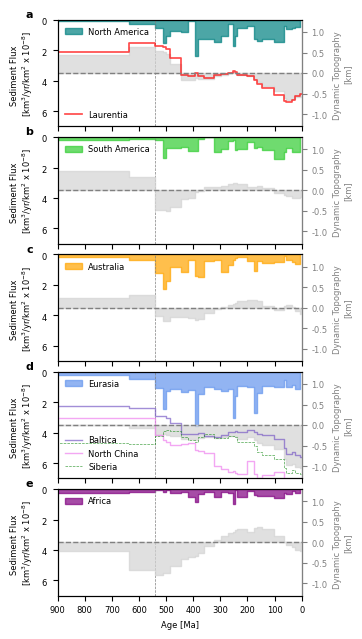

In [12]:
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches
import pandas as pd

incm = 1 / 2.54

n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


#---------------------------------- Colored age axes corresponding to geological period--------------------------------#
age_intervals = [
    ("Neoproterozoic", 1000, 541, "#fc8d59"),
    ("Cambrian", 541, 485, "#91cf60"),
    ("Ordovician", 485, 444, "#1a9850"),
    ("Silurian", 444, 419, "#67a9cf"),
    ("Devonian", 419, 359, "#3690c0"),
    ("Carboniferous", 359, 299, "#0571b0"),
    ("Permian", 299, 252, "#fdae61"),
    ("Mesozoic", 252, 66, "#fee08b"),
    ("Cenozoic", 66, 0, "#ffffbf"),
]

ronov_fpath=glob.glob('*.xls')[0]
#Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values_org(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    # reverse order accumulation (like Julia)
    for i, key in enumerate(continent_keys):
        
        total = np.zeros(len(x))
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values / dt /contarea[i] *1e8)  # (contarea[i])area averaged continental sediments (km3/yr/km2) [::-1] reverses the order as reversed for continents
        vol_cumulative[:, i] = total
        #print(f'{key}:{ronov[key].head()}: {vol_cumulative}')
    return total, vol_cumulative

# Compute Neoproterozoic and  Phanerozoic mean

# --- Compute mean flux in given intervals ---
def compute_mean_flux(x, flux):
    """
    Compute mean flux for Neoproterozoic (1000–541 Ma)
    and Phanerozoic (541–0 Ma).
    """
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)

    neo_mean = np.nanmean(flux[neo_mask])
    phan_mean = np.nanmean(flux[phan_mask])
    return neo_mean, phan_mean


# --- Plot each continent by itself ---
continents = ["North America",  "South America", "Australia", "Eurasia", "Africa"]
continent_keys = [ "Ronov_NAm",  "Ronov_SAm", "Ronov_Aus", "Ronov_Eur", "Ronov_Afr"]
continentcolors = [ 'teal', 'limegreen', 'orange',  'cornflowerblue', 'purple']
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = [  "LAU",  "AMZ", "AUS", "EAS", "AFR"]
contarea = [24.228E6, 18.28E6, 8.8015E6,  53.4E6, 30.3E6]

#labels
fig_labels =['a','b','c','d','e','f']

fig, axes = plt.subplots(5, 1, figsize=(8*incm,19*incm), sharex=True)



total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)

total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)
print(len(x_ronov),len(vol_cumulative_ronov[:,0]), len(vol_cumulative_DT))

for i, ax in enumerate(axes.flatten()):
    if i==5:
        ax.set_visible(False)
    else:
        ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
        #ax.fill_between(x, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
        
        ax1=ax.twinx()
        ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values), color='lightgrey', alpha=0.7)
        #legend
        ax.legend(loc='upper left', frameon=False, facecolor="None", fontsize=6)
        
        ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
        ax.set_xlim(0, 900)
        if i >2:
            #ax.set_ylim(0,0.8)
            ax1.set_ylim(-700,900)
        elif i==2:
            #ax.set_ylim(0,2)
            ax1.set_ylim(-700,1200)
        else:
            #ax.set_ylim(0, 7)
            ax1.set_ylim(-1200, 1200)
        #ax.set_ylim(0, 7)
        # Configure the x-axis to display tick labels in scientific notation
        # using a ScalarFormatter
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
        
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(0, 7) 

        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
        #plot additional continental stepped DT
        if i==4:
            # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='k', alpha=0.7, linestyle='--', linewidth=0.75)
            # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
            # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='chocolate', alpha=0.7, linestyle='--',linewidth=0.75)
            # ax1.legend(loc="lower right", frameon=False, facecolor="None")
            pass

        elif i==3:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=1)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='green', alpha=0.7, linestyle='--',linewidth=0.5)
            
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
        elif i==0:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='red', alpha=0.7, linestyle='-',linewidth=1.25)
            ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)

        # ticks fontsize
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax1.tick_params(axis='both', which='major', labelsize=6)
        
        
        ax1.set_ylim(-1300, 1300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        #ax.set_title(continents[i])
        if i ==4:
            ax.set_xlabel('Age [Ma]', fontsize=6)
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
        ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)

        # #compute mean# --- Compute & plot mean flux lines ---
        # neo_mean, phan_mean = compute_mean_flux(x_ronov, vol_cumulative_ronov[:, i])
        # ax.hlines(neo_mean, 1000, 541, color='red', linestyle='--', linewidth=0.75,)
        # ax.hlines(phan_mean, 541, 0, color='blue', linestyle='--', linewidth=0.75,)
        # plt.text(
        # 0.3, 0.85, f"Π = {phan_mean/neo_mean :.1f}",
        # transform=plt.gca().transAxes,
        # fontsize=6, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
        #     )
        

        def meters_to_km(x, pos):
            return f"{x/1000:.1f}"  # divide by 1000 to get km
               
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
        #ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3)) 
        ax1.spines["right"].set_color("grey")
        #ax.legend(loc=[0.75, 0.65], frameon=False, facecolor="None", fontsize=8 )
        #ax.set_title(continents[i], fontsize=8)

        # # --- Draw colored rectangles ---
        # for label, start, end, color in age_intervals:
    
        #     ax1.axvspan(start, end, ymin=0, ymax=0.1, color=color, zorder=0, clip_on=False)
        ax.text(-0.1, 1.1, fig_labels[i], transform=ax.transAxes,
            fontsize=8, fontweight='bold', va='top', ha='right')

    # ax1.set_xlim(0, 1000)
    # #ax1.set_ylim(-1300, 100)
    # ax2.set_ylim(-1200, 1200)
    # ax1.invert_xaxis()
#ax2.invert_xaxis()
fig.subplots_adjust(wspace=0.05, hspace=0.1)
#plt.savefig('./SedimentvsDT_M6_model.png', dpi=600, bbox_inches='tight')
plt.show()

   b_age  t_age         LAU
0    540      0 -165.149139
1   1000    540  544.485962
   b_age  t_age         AMZ
0    120      0 -138.369736
1    380    120  118.562851
2    540    380 -298.395691
3    900    540  318.888733
   b_age  t_age         AUS
0    120      0  -25.447199
1    280    120  135.914642
2    540    280 -229.860184
3    900    540  305.146912
   b_age  t_age         EAS
0    540      0 -464.558228
1    900    540  -62.290993
   b_age  t_age         AFR
0     60      0 -133.362076
1    300     60  270.302002
2    900    300 -502.840424


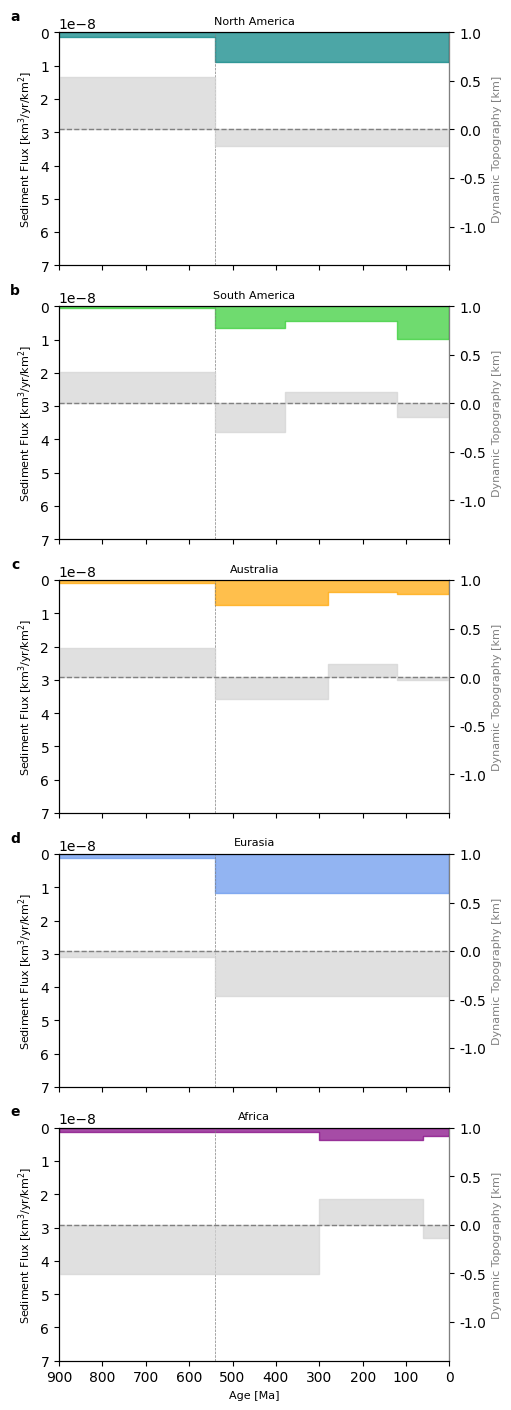

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# --- Cycles definitions ---
ronov_cycles = {
    'Ronov_NAm': [(540,0),  (1000,540)],
    'Ronov_SAm': [(120,0),(380,120),(540,380), (900,540),],
    'Ronov_Aus': [(120,0),(280,120),(540,280),(900,540)],
    'Ronov_Eur': [(540,0), (900,540),],
    'Ronov_Afr': [(60,0),(300,60),(900,300)]
}
dt_cycles = {
    'LAU': [(540,0),  (1000,540)],
    'AMZ': [(120,0),(380,120),(540,380), (900,540),],
    'AUS': [(120,0),(280,120),(540,280),(900,540)],
    'EAS': [(540,0), (900,540),],
    'AFR': [(60,0),(300,60),(900,300)]
}

ronov_fpath=glob.glob('*.xls')[0]
 #Keller sedimentary dataframe
ronov_keller_data = pd.read_excel(ronov_fpath)
ronov= ronov_keller_data.copy().iloc[:-1,:]

# --- Aggregate to custom cycles ---
def aggregate_to_custom_cycles(df, intervals, cont):
    results = []
    for (b, t) in intervals:
        mask = (df["b_age"] <= b) & (df["t_age"] >= t)
        subset = df.loc[mask, [cont]]
        if not subset.empty:
            if "Ronov" in cont:   # sediments → sum
                val = subset[cont].sum()
            elif "DT" in cont:    # topography → mean
                val = subset[cont].mean()
            else:
                val = subset[cont].mean()
            results.append({"b_age": b, "t_age": t, cont: val})
    return pd.DataFrame(results)

# --- Helpers ---
def repeat_inner(arr): return np.repeat(arr, 2)

def compute_cumulative_values(x, df, continent, dt, cont_area):
    vol_cumulative = np.zeros((len(x), len(continent)))
    for i, key in enumerate(continent):
        total = repeat_inner(df[key].values / dt / cont_area)
        vol_cumulative[:, i] = total
    return total, vol_cumulative

def compute_mean_flux(x, flux):
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)
    return np.nanmean(flux[neo_mask]), np.nanmean(flux[phan_mask])

def meters_to_km(x, pos): return f"{x/1000:.1f}"

# --- Setup ---
continents     = ["North America","South America","Australia","Eurasia","Africa"]
continent_keys = ["Ronov_NAm","Ronov_SAm","Ronov_Aus","Ronov_Eur","Ronov_Afr"]
DT_keys        = ["LAU","AMZ","AUS","EAS","AFR"]
colors         = ['teal','limegreen','orange','cornflowerblue','purple']
contarea       = [24.228E6,18.28E6,8.8015E6,53.4E6,30.3E6]
fig_labels     = ['a','b','c','d','e']

fig, axes = plt.subplots(5, 1, figsize=(5,14), layout='constrained', sharex=True)

for i, ax in enumerate(axes):
    # aggregate
    ronov_res = aggregate_to_custom_cycles(ronov, ronov_cycles[continent_keys[i]], continent_keys[i])
    
    dt_res    = aggregate_to_custom_cycles(stepped_continental_DT, dt_cycles[DT_keys[i]], DT_keys[i])
    print(dt_res)
    
    # expand steps
    x_ronov = np.vstack([ronov_res["t_age"].values, ronov_res["b_age"].values]).T.flatten()
    dt_vals = ronov_res["b_age"].values - ronov_res["t_age"].values
    
    total_ronov, vol_cum = compute_cumulative_values(x_ronov, ronov_res, [continent_keys[i]], dt_vals, contarea[i])

    # plot sediment flux
    ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
    ax.fill_between(x_ronov, vol_cum[:,0], step="mid", color=colors[i], alpha=0.7, label=continents[i])
    ax.set_ylabel(r"Sediment Flux [km$^3$/yr/km$^2$]", fontsize=8)
    ax.set_xlim(0,900)
    ax.set_ylim(0, 7e-8)
    ax.invert_xaxis()
    ax.invert_yaxis()

    # plot DT
    ax1 = ax.twinx()
    ax1.set_ylim(-1400, 1000)
    ax1.fill_between(x_ronov, repeat_inner(dt_res[DT_keys[i]].values), color='lightgrey', alpha=0.7)
    ax1.set_ylabel(r"Dynamic Topography [km]", color='grey', fontsize=8)
    ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
    ax1.spines["right"].set_color("grey")
    ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')

    # mean flux lines
    # neo_mean, phan_mean = compute_mean_flux(x_ronov, vol_cum[:,0])
    # ax.hlines(neo_mean, 1000, 541, color='red', linestyle='--', linewidth=0.75)
    # ax.hlines(phan_mean, 541, 0, color='blue', linestyle='--', linewidth=0.75)
    # ax.text(0.3, 0.85, f"Π = {phan_mean/neo_mean :.1f}", transform=ax.transAxes,
    #         fontsize=6, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

    # labels
    if i == 4: ax.set_xlabel('Age [Ma]', fontsize=8)
    ax.set_title(continents[i], fontsize=8)
    ax.text(-0.1, 1.1, fig_labels[i], transform=ax.transAxes,
            fontsize=10, fontweight='bold', va='top', ha='right')

plt.show()


   b_age  t_age         LAU
0    540      0 -165.149139
1   1000    540  544.485962
   b_age  t_age         EAS
0    540      0 -464.558228
1    900    540  -62.290993
   b_age  t_age         AMZ
0    120      0 -138.369736
1    380    120  118.562851
2    540    380 -298.395691
3    900    540  318.888733
   b_age  t_age         AUS
0    120      0  -25.447199
1    280    120  135.914642
2    540    280 -229.860184
3    900    540  305.146912
   b_age  t_age         AFR
0     60      0 -133.362076
1    300     60  270.302002
2    900    300 -502.840424


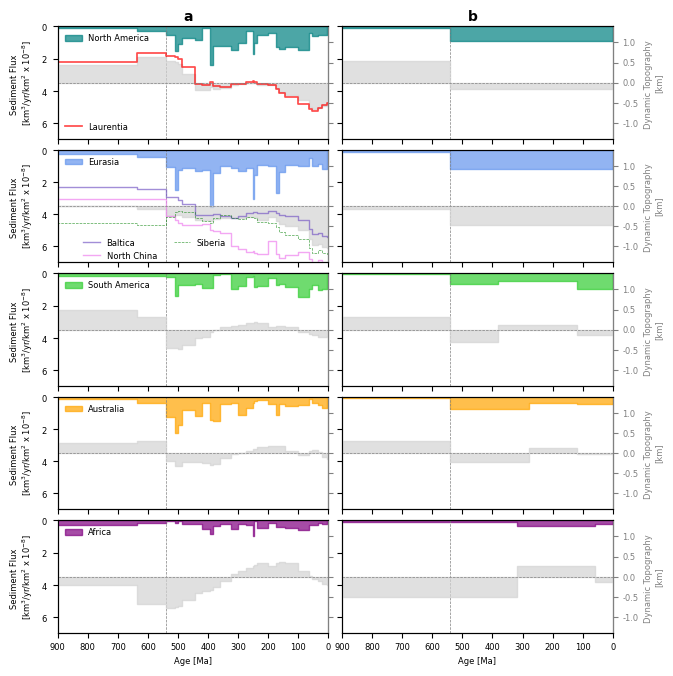

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

# --- Setup ---
continents     = ["North America","Eurasia","South America","Australia","Africa"]
continent_keys = ["Ronov_NAm","Ronov_Eur","Ronov_SAm","Ronov_Aus","Ronov_Afr"]
#continent_names= [ 'LAU','EAS', 'AMZ','AUS', 'AFR']
DT_keys        = ["LAU","EAS","AMZ","AUS","AFR"]
colors         = ['teal','cornflowerblue','limegreen','orange','purple']
contarea       = [24.228E6,53.4E6,18.28E6,8.8015E6,30.3E6]
#fig_labels     = ['a','b','c','d','e']
fig_labels     = ['a','b']

# --- Cycles definitions ---
ronov_cycles = {
    'Ronov_NAm': [(540,0),  (1000,540)],
    'Ronov_Eur': [(540,0), (900,540),],
    #'Ronov_SAm': [(180,0),(380,180),(540,380), (900,540),], #old
    #'Ronov_Aus': [(180,0),(320,180),(540,320),(900,540)], #old
    'Ronov_SAm': [(120,0),(380,120),(540,380), (900,540),],
    'Ronov_Aus': [(120,0),(280,120),(540,280),(900,540)],
    'Ronov_Afr': [(60,0),(320,60),(900,320)]
}
dt_cycles = {
    'LAU': [(540,0),  (1000,540)],
    'EAS': [(540,0), (900,540),],
    # 'AMZ': [(180,0),(380,180),(540,380), (900,540)], #old
    # 'AUS': [(180,0),(320,180),(540,320),(900,540)],  #old
    'AMZ': [(120,0),(380,120),(540,380), (900,540),],
    'AUS': [(120,0),(280,120),(540,280),(900,540)],
    'AFR': [(60,0),(300,60),(900,300)]
}

#-----orginal ronov cycles----------------------------#
ronov_df = pd.read_excel(glob.glob('*.xls')[0])
org_ronov_cycles = { continent_key : list(zip(ronov_df['b_age'], ronov_df['t_age'])) for continent_key  in continent_keys}
org_dt_cycles = { dt_key : list(zip(ronov_df['b_age'], ronov_df['t_age'])) for dt_key  in DT_keys}

# --- Aggregate to custom cycles ---
def aggregate_to_custom_cycles(df, intervals, cont):
    results = []
    for (b, t) in intervals:
        mask = (df["b_age"] <= b) & (df["t_age"] >= t)
        subset = df.loc[mask, [cont]]
        if not subset.empty:
            if "Ronov" in cont:   # sediments → sum
                val = subset[cont].sum()
            elif "DT" in cont:    # topography → mean
                val = subset[cont].mean()
            else:
                val = subset[cont].mean()
            results.append({"b_age": b, "t_age": t, cont: val})
    return pd.DataFrame(results)

# --- Helpers ---
def repeat_inner(arr): return np.repeat(arr, 2)

def compute_cumulative_values(x, df, continent, dt, cont_area):
    vol_cumulative = np.zeros((len(x), len(continent)))
    for i, key in enumerate(continent):
        total = repeat_inner(df[key].values / dt / cont_area *1e8) 
        vol_cumulative[:, i] = total 
    return total, vol_cumulative

def compute_mean_flux(x, flux):
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)
    return np.nanmean(flux[neo_mask]), np.nanmean(flux[phan_mask])

def meters_to_km(x, pos): return f"{x/1000:.1f}"

# compute DT and sedimentary flux at ROnov's time steps
x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
# dt = ronov["b_age"].values - ronov["t_age"].values
# dt[0] = np.nan  # Exclude Quaternary alluvium

total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)

total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)


fig, axes = plt.subplots(5, 2, figsize=(18.2*incm,20*incm), sharex=True, sharey=True)

for j in range(2):
    for i, ax in enumerate(axes[:,j]):
        if j ==1:
        
        # aggregate
            ronov_res = aggregate_to_custom_cycles(ronov, ronov_cycles[continent_keys[i]], continent_keys[i])
            
            dt_res    = aggregate_to_custom_cycles(stepped_continental_DT, dt_cycles[DT_keys[i]], DT_keys[i])
            print(dt_res)
            
            # expand steps
            x_ronov_stepped = np.vstack([ronov_res["t_age"].values, ronov_res["b_age"].values]).T.flatten()
            dt_vals = ronov_res["b_age"].values - ronov_res["t_age"].values
            
            total_ronov, vol_cum = compute_cumulative_values(x_ronov_stepped, ronov_res, [continent_keys[i]], dt_vals, contarea[i])

           
            
        
            # plot sediment flux
            ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
           
            
            ax.fill_between(x_ronov_stepped, vol_cum[:,0], step="mid", color=colors[i], alpha=0.7, label=continents[i])
            # ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
            ax.set_xlim(0,900)
            ax.set_ylim(0, 7)
            ax.invert_xaxis()
            ax.invert_yaxis()
        
            # plot DT
            ax1 = ax.twinx()
            ax1.set_ylim(-1400, 1400)
            ax1.fill_between(x_ronov_stepped, repeat_inner(dt_res[DT_keys[i]].values), color='lightgrey', alpha=0.7)
            
            def meters_to_km(x, pos):
                return f"{x/1000:.1f}"  # divide by 1000 to get km
                   
            ax1.tick_params(axis="y", colors="grey")
            ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
            ax1.spines["right"].set_color("grey")
            ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)
            # labels
            if i == 4: 
                ax.set_xlabel('Age [Ma]', fontsize=6)
                        
            ax1.set_ylabel("Dynamic Topography \n[km]", color='grey', fontsize=6)
             # ticks fontsize
            ax1.axhline(y=0, c='grey', linewidth=0.5, linestyle='--')
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax1.tick_params(axis='both', which='major', labelsize=6)
            
        else:
            ax.axvline(x=540, c='grey', linewidth=0.5, linestyle='--')
            #ax.fill_between(x, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
            ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=colors[i], alpha=0.7)
            #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
            
            ax1=ax.twinx()
            ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_keys[i]].values), color='lightgrey', alpha=0.7)
            #legend
            ax.legend(loc='upper left', frameon=False, facecolor="None", fontsize=6)
            
            ax.set_ylabel("Sediment Flux \n[km$^3$/yr/km$^2$ x 10$^{-8}$]", fontsize=6)
            ax.set_xlim(0, 900)
            if i >2:
                #ax.set_ylim(0,0.8)
                ax1.set_ylim(-700,900)
            elif i==2:
                #ax.set_ylim(0,2)
                ax1.set_ylim(-700,1200)
            else:
                #ax.set_ylim(0, 7)
                ax1.set_ylim(-1200, 1200)
            #ax.set_ylim(0, 7)
            # Configure the x-axis to display tick labels in scientific notation
            # using a ScalarFormatter
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
            
            ax.yaxis.set_major_formatter(formatter)
            ax.set_ylim(0, 7) 
    
            #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
            #plot additional continental stepped DT
            if i==4:
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='k', alpha=0.7, linestyle='--', linewidth=0.75)
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
                # ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='chocolate', alpha=0.7, linestyle='--',linewidth=0.75)
                # ax1.legend(loc="lower right", frameon=False, facecolor="None")
                pass
    
            elif i==1:
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='-',linewidth=1)
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=1)
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='green', alpha=0.7, linestyle='--',linewidth=0.5)
                
               # ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6, ncol=1)
                ax1.legend(loc='best', bbox_to_anchor=(0.15, -0.05, 0.5, 0.5), frameon=False, facecolor="None", fontsize=6, ncol=2)
                
            elif i==0:
                ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='red', alpha=0.7, linestyle='-',linewidth=1.25)
                ax1.legend(loc="lower left", frameon=False, facecolor="None", fontsize=6)
    
            
            
            
            ax1.set_ylim(-1400, 1400)
            ax.invert_xaxis()
            ax.invert_yaxis()
            #ax.set_title(continents[i])
            if i ==4:
                ax.set_xlabel('Age [Ma]', fontsize=6)
            
            ax1.axhline(y=0, c='grey', linewidth=0.5, linestyle='--')
            
    
            def meters_to_km(x, pos):
                return f"{x/1000:.1f}"  # divide by 1000 to get km
                   
            #ax1.set_ylabel("Secondary Y", color="red")
            ax1.tick_params(axis="y", colors="grey")
            ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
            ax1.spines["right"].set_color("grey")
            ax1.tick_params(axis='y', right=True, labelright=False)
            # ticks fontsize
            ax.tick_params(axis='both', which='major', labelsize=6)
            ax1.tick_params(axis='both', which='major', labelsize=6)
    
        if i==0:
            #     ax1.axvspan(start, end, ymin=0, ymax=0.1, color=color, zorder=0, clip_on=False)
            ax.text(0.5, 1.15, fig_labels[j], transform=ax.transAxes,
                fontsize=10, fontweight='bold', va='top', ha='right')

fig.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig('./SedimentvsDT-in-Ronov-DTcycles_M6_model.png', dpi=600, bbox_inches='tight')
plt.show()

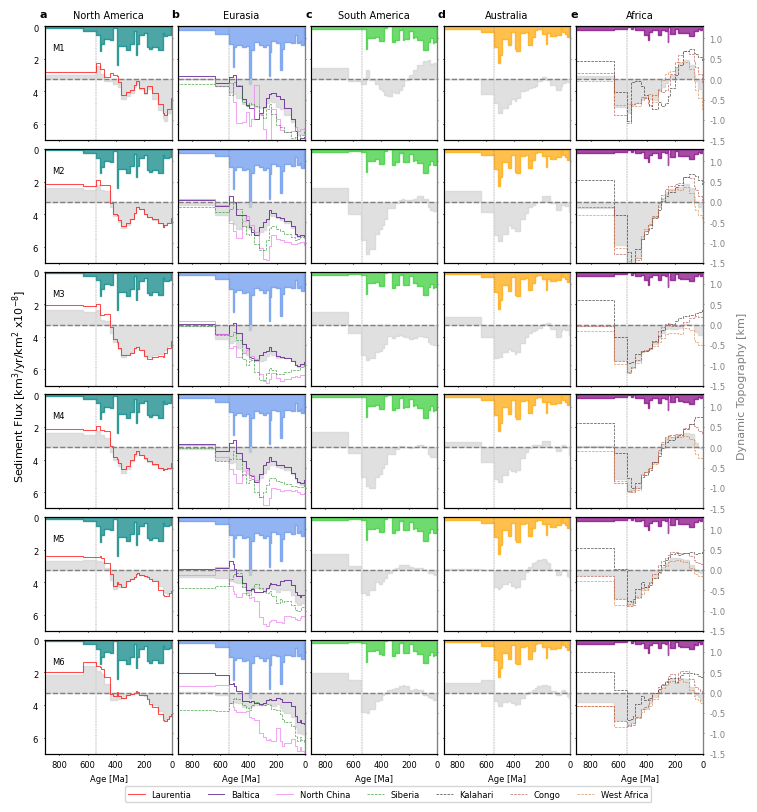

In [24]:
from matplotlib import cm
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as patches

incm = 1 / 2.54

n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))

#---------------------------------- Colored age axes corresponding to geological period--------------------------------#
age_intervals = [
    ("Neoproterozoic", 1000, 541, "#fc8d59"),
    ("Cambrian", 541, 485, "#91cf60"),
    ("Ordovician", 485, 444, "#1a9850"),
    ("Silurian", 444, 419, "#67a9cf"),
    ("Devonian", 419, 359, "#3690c0"),
    ("Carboniferous", 359, 299, "#0571b0"),
    ("Permian", 299, 252, "#fdae61"),
    ("Mesozoic", 252, 66, "#fee08b"),
    ("Cenozoic", 66, 0, "#ffffbf"),
]


# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    # reverse order accumulation (like Julia)
    for i, key in enumerate(continent_keys):
        
        total = np.zeros(len(x))
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values *1e8 / dt /contarea[i] )  # (contarea[i])area averaged continental sediments (km3/yr/km2) [::-1] reverses the order as reversed for continents
        vol_cumulative[:, i] = total
        #print(f'{key}:{ronov[key].head()}: {vol_cumulative}')
    return total, vol_cumulative

# Compute Neoproterozoic and  Phanerozoic mean

# --- Compute mean flux in given intervals ---
def compute_mean_flux(x, flux):
    """
    Compute mean flux for Neoproterozoic (1000–541 Ma)
    and Phanerozoic (541–0 Ma).
    """
    neo_mask = (x <= 1000) & (x >= 541)
    phan_mask = (x <= 541) & (x >= 0)

    neo_mean = np.nanmean(flux[neo_mask])
    phan_mean = np.nanmean(flux[phan_mask])
    return neo_mean, phan_mean


# --- Plot each continent by itself ---
continents = ["North America",  "Eurasia","South America", "Australia",  "Africa"]
continent_keys = [ "Ronov_NAm", "Ronov_Eur",  "Ronov_SAm", "Ronov_Aus", "Ronov_Afr"]
continentcolors = [ 'teal', 'cornflowerblue','limegreen', 'orange',   'purple']
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = [  "LAU", "EAS", "AMZ", "AUS",  "AFR"]
additional_continents = ['SIB', 'CON', 'KAL','WAC','BAL', 'NA', 'NCC']
contarea = [24.228E6, 53.4E6, 18.28E6, 8.8015E6,   30.3E6]
models=[ 'gld421','gld428', 'gld431', 'gld434', 'gld486', 'gld504']
model_labels =['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
#labels
fig_labels =['a','b','c','d','e','f']

fig, axes = plt.subplots(6, 5, figsize=(20*incm,24*incm), sharex=True, sharey=True)

def sync_ylim(ax_list):
    """Synchronize ylim across multiple twin axes"""
    # find global min/max
    ymin = min(ax.get_ylim()[0] for ax in ax_list)
    ymax = max(ax.get_ylim()[1] for ax in ax_list)
    for ax in ax_list:
        ax.set_ylim(ymin, ymax)

secondary_axes =[]
for j, model in enumerate(models):
    

    ronov=pd.read_excel(glob.glob('*.xls')[0]).iloc[:-1,:]
   
    stepped_continental_DT = extract_DT_to_ronov_steps(ronov, DT_continent_keys, model, continent_type ='main')
    BaSiC_KaWA = extract_DT_to_ronov_steps(ronov, additional_continents, model,continent_type ='additional')
    
    x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
    
    dt = ronov["b_age"].values - ronov["t_age"].values
    dt[0] = np.nan  # Exclude Quaternary alluvium
    
    
    total_ronov, vol_cumulative_ronov = compute_cumulative_values_org(x_ronov, continent_keys)
    
    total_DT, vol_cumulative_DT = compute_cumulative_values_org(x_ronov, DT_continent_keys)

    
    
    for i, ax in enumerate(axes[j].flatten()):
       
        ax.axvline(x=540, c='grey', linewidth=0.35, linestyle='--')
        #ax.fill_between(x, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        ax.fill_between(x_ronov, vol_cumulative_ronov[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
        
        ax1=ax.twinx()
        
        ax1.fill_between(x_ronov, repeat_inner(stepped_continental_DT[DT_continent_keys[i]].values), color='lightgrey', alpha=0.7)
        #ax.set_xlabel("Age (Ma)")
        
        ax.set_xlim(0, 900)
        # if i >2:
        #     #ax.set_ylim(0,0.8)
        #     ax1.set_ylim(-700,900)
        # elif i==2:
        #     #ax.set_ylim(0,2)
        #     ax1.set_ylim(-700,1200)
        # else:
        #     #ax.set_ylim(0, 7)
        #     ax1.set_ylim(-1200, 1200)
        #ax.set_ylim(0, 7)
        # Configure the x-axis to display tick labels in scientific notation
        # using a ScalarFormatter
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-3, 4)) # Display scientific notation for values outside 10^-3 to 10^4
        
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(0, 7) 

        #ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -8)) 
        #plot additional continental stepped DT
        if i==4:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['KAL'].values), label='Kalahari', color='k', alpha=0.7, linestyle='--', linewidth=0.5)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.5)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['WAC'].values), label='West Africa', color='chocolate', alpha=0.7, linestyle='--',linewidth=0.5)
            #ax1.legend(loc="lower right", frameon=False, facecolor="None")

        elif i==1:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['BAL'].values), label='Baltica', color='indigo', alpha=0.7, linestyle='-',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NCC'].values), label='North China', color='violet', alpha=0.7, linestyle='-',linewidth=0.75)
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['SIB'].values), label='Siberia', color='green', alpha=0.7, linestyle='--',linewidth=0.5)
            
            #ax1.legend(loc="lower left", frameon=False, facecolor="None")
        elif i==0:
            ax1.plot(x_ronov, repeat_inner(BaSiC_KaWA['NA'].values), label='Laurentia', color='red', alpha=0.7, linestyle='-',linewidth=0.75)
            #ax1.legend(loc="lower left", frameon=False, facecolor="None")

        ax1.set_ylim(-1500, 1300)
        ax.invert_xaxis()
        ax.invert_yaxis()
        #ax.set_title(continents[i])
        # if i ==4:
        #     ax.set_xlabel('Age [Ma]', fontsize=8)
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')

        def meters_to_km(x, pos):
            return f"{x/1000:.1f}"  # divide by 1000 to get km
               
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ncols = axes.shape[1]
        col = i % ncols
        if col != ncols - 1:
            ax1.tick_params(labelleft=False, labelright=False)
        ax1.set_ylabel("") 
        ax1.yaxis.set_major_formatter(FuncFormatter(meters_to_km))
        #ax1.ticklabel_format(style='sci', axis='y', scilimits=(-3, 3)) 
        ax1.spines["right"].set_color("grey")

        # # --- Draw colored rectangles ---
        # for label, start, end, color in age_intervals:
        ax.tick_params(axis='both', which='major', labelsize=6, length=1)  # major ticks
        ax1.tick_params(axis='both', which='major', labelsize=6, length=1)  # minor ticks (if any)
        #     ax1.axvspan(start, end, ymin=0, ymax=0.1, color=color, zorder=0, clip_on=False)
        if j==0:
            ax.text(0.01, 1.15, fig_labels[i], transform=ax.transAxes,
                fontsize=8, fontweight='bold', va='top', ha='right')
            ax.set_title(continents[i], fontsize=7)
        # if j ==3 and i==0:
            
        # #     ax.set_ylabel(r"Sediment Flux [km$^3$/yr/km$^2$ x10$^{-8}$]", fontsize=8)
        # if j==3 and i==4:
        #     ax1.set_ylabel(r"Dynamic Topography [km]", color='grey', fontsize=8)
        # if j ==5:
        #     ax1.legend(loc="lower right", frameon=False, facecolor="None", fontsize =5)  
        # Collect all handles and labels once for the legend
        if j==5:
            secondary_axes.append(ax1)
            ax.set_xlabel('Age [Ma]', fontsize=6)
            
        if i==0:
             ax.text(0.15, 0.85, model_labels[j], transform=ax.transAxes,
                    fontsize=6, va='top', ha='right')
fig.supylabel(r"Sediment Flux [km$^3$/yr/km$^2$ x10$^{-8}$]", fontsize=8)
# use fig-level text as pseudo-supylable for right-axis
fig.text(x=0.95, y=0.5, s=r"Dynamic Topography [km]", size=8, rotation=90, ha='center', va='center', color='grey')
            
handles_labels = [ax1.get_legend_handles_labels() for ax1 in secondary_axes]
handles, labels = zip(*handles_labels)
handles = [h for sublist in handles for h in sublist]
labels = [l for sublist in labels for l in sublist]
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.08), ncol=7, fontsize=6)
        
fig.subplots_adjust(left=0.065, wspace=0.05, hspace=0.075)
plt.savefig('./SedimentvsDT_all_models.png', dpi=600, bbox_inches='tight')
plt.show()

# DT rate of change

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.stats import rankdata

# def pettitt_change_detection(df, time_col="time", value_col="value", plot=True, continent='None'):
#     """
#     Apply Pettitt's test to detect a change point in a time series DataFrame.

#     Parameters
#     ----------
#     df : pandas.DataFrame
#         Input DataFrame with a time column and a value column.
#     time_col : str, default="time"
#         Name of the datetime column.
#     value_col : str, default="value"
#         Name of the series column to test.
#     plot : bool, default=True
#         Whether to generate a plot of the results.

#     Returns
#     -------
#     results : dict
#         Dictionary with test statistic, p-value, change index, change date, and direction.
#     """

#     series = df[value_col].values
#     n = len(series)
#     r = rankdata(series)
#     U = np.zeros(n)

#     for k in range(n):
#         U[k] = 2 * np.sum(r[:k+1]) - (k+1) * (n+1)

#     K = np.max(np.abs(U))
#     K_index = np.argmax(np.abs(U))
#     p = 2 * np.exp((-6 * K**2) / (n**3 + n**2))

#     before_mean = np.mean(series[:K_index])
#     after_mean = np.mean(series[K_index:])
#     direction = "increase" if after_mean > before_mean else "decrease"

#     change_date = df[time_col].iloc[K_index]

#     results = {
#         "statistic": K,
#         "p_value": p,
#         "change_index": K_index,
#         "change_date": change_date,
#         "direction": direction,
#         "before_mean": before_mean,
#         "after_mean": after_mean,
#     }

#     if plot:
#         plt.figure(figsize=(10,5))
#         plt.plot(df[time_col], df[value_col], marker="o", linestyle="-", label="Data")
        
#         # Change point
#         plt.axvline(change_date, color="red", linestyle="--", label="Change point")

#         # Annotate direction
#         plt.text(change_date, df[value_col].max(), f"Shift: {direction}",
#                  color="red", fontsize=12, ha="left", va="top")

#         # Mean lines
#         plt.hlines(before_mean, df[time_col].iloc[0], change_date,
#                    colors="blue", linestyles="--", label="Before mean")
#         plt.hlines(after_mean, change_date, df[time_col].iloc[-1],
#                    colors="green", linestyles="--", label="After mean")

#         plt.title(f"Pettitt Test for Abrupt Change-{continent}")
#         plt.xlabel("Time")
#         plt.ylabel(value_col)
#         plt.gca().invert_xaxis()
#         plt.legend()
#         plt.tight_layout()
#         plt.show()

#     return results

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rankdata

# --- Pettitt single test ---
def pettitt_test(x):
    n = len(x)
    ranks = rankdata(x)
    U = np.zeros(n)
    for k in range(n):
        U[k] = 2*np.sum(ranks[:k+1]) - (k+1)*(n+1)
    K = np.max(np.abs(U))
    K_index = np.argmax(np.abs(U))
    p = 2 * np.exp((-6 * K**2) / (n**3 + n**2))
    return K_index, K, p

# --- Recursive multi-change detection ---
def recursive_pettitt(x, start=0, min_size=10, alpha=0.05):
    if len(x) < 2*min_size:
        return []
    idx, _, p = pettitt_test(x)
    if p < alpha and idx >= min_size and idx <= len(x)-min_size:
        cp_left = recursive_pettitt(x[:idx], start=start, min_size=min_size, alpha=alpha)
        cp_right = recursive_pettitt(x[idx:], start=start+idx, min_size=min_size, alpha=alpha)
        return cp_left + [start+idx] + cp_right
    else:
        return []

# --- Main function ---
def detect_plot_pettitt_enhanced(df, x_col, y_col, alpha=0.05, min_size=10, figsize=(14,6), title="Pettitt Multi-Change Detection"):
    """
    Detect multiple statistically significant change points using Pettitt test,
    reverse x-axis, compute rate and direction, and plot enriched visualization:
    - signal with inverted x-axis
    - change points
    - segment means
    - colored segments by direction
    - annotated rate of change
    """
    # Reverse data
    df_rev = df.iloc[::-1].reset_index(drop=True)
    x = df_rev[x_col].values
    y = df_rev[y_col].values
    
    # Detect change points
    change_points = recursive_pettitt(y, start=0, min_size=min_size, alpha=alpha)
    change_points = sorted(change_points)
    
    # Add start and end for segmenting
    segments = [0] + change_points + [len(y)]
    
    # Prepare results
    result_list = []
    
    plt.figure(figsize=figsize)
    
    for i in range(len(segments)-1):
        start, end = segments[i], segments[i+1]
        x_seg, y_seg = x[start:end], y[start:end]
        mean_seg = np.mean(y_seg)
        # Compute rate
        dx = x_seg[-1] - x_seg[0]
        dy = y_seg[-1] - y_seg[0]
        rate = dy/dx if dx != 0 else np.nan
        direction = "up" if rate > 0 else ("down" if rate < 0 else "flat")
        
        # Store results
        result_list.append({
            "segment_start_idx": start,
            "segment_end_idx": end-1,
            x_col: x[start],
            y_col: y[start],
            "rate": rate,
            "direction": direction,
            "mean": mean_seg
        })
        
        # Plot segment with color by direction
        color = "green" if direction=="up" else ("red" if direction=="down" else "blue")
        plt.plot(x_seg, y_seg, color=color, linewidth=2)
        plt.hlines(mean_seg, x_seg[0], x_seg[-1], colors="black", linestyles="dashed", linewidth=1)
        plt.text(x_seg[-1], mean_seg, f"{rate:.2f}", color="black", fontsize=9, va="bottom")
        
        # Mark change point at segment end (except last)
        if i < len(segments)-2:
            plt.axvline(x=x[segments[i+1]], color="black", linestyle="--")
    
    plt.gca().invert_xaxis()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(title)
    plt.show()
    
    result_df = pd.DataFrame(result_list)
    return result_df



In [ ]:
import pygmt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic
from shapely import wkt

model ='gld504'
continent_names= [ 'LAU','AMZ','AFR','AUS', 'EAS']
additional_continents = ['SIB', 'CON', 'KAL','WAC','BAL']
colors =['forestgreen','blue', 'red','cyan', 'brown']



ronov_fpath=glob.glob('*.xls')[0]
DTrate_change_files = glob.glob(f'../Model_data/{model}/{model}_PlateFrameRate*.nc')
sorted_DTrate_files = sort_files_by_age(DTrate_change_files, match_string='Rate')
DTrate_nc = filepath_to_nc(sorted_DTrate_files)

#-----------------------filter nc file upto 920 Ma and filter it with 920 Ma Nc file---------------#
DTrate_nc = DTrate_nc.sel(age = slice(0,810))
maskrate_920 = DTrate_nc.sel(age=810)
DTrate_nc = DTrate_nc.where(mask_920)
    

#---------------------------- Extract data to Ronov's Df--------------------------------------#
def extract_DTrate_to_ronov_steps(ronov_fpath, DTrate_ncs, continent_names, continent_type ='main'):

   
    
    continents_dtrate ={}
    for continent, color in zip(continent_names, colors):
        #-------------------------extract DT rate of change for each continent-----------------------------#
        #1.load gpml files for each continent
        if continent_type =='main': 
            continent_df = gpd.read_file(glob.glob(f'./{model}_{continent}*.gpml')[0])
        else:
            continent_df = gpd.read_file(glob.glob(f'../{model}_{continent}*.gpml')[0])
        
        continent_df=continent_df.explode(index_parts=True, ignore_index=False) 

        #extract values to points
        DTrate_values = DTrate_ncs.z.sel(
                lon=xr.DataArray(list(continent_df.geometry.x), dims="points"),
                lat=xr.DataArray(list(continent_df.geometry.y), dims="points"),
                method="nearest"
            )
        
        
        
        # -----------------------nc to spatially averaged dataframe------------------------#
        df = DTrate_values.mean(dim=['points']).to_dataframe().reset_index()

        #pettitt_change_detection(df, time_col="age", value_col="z", plot=True, continent=continent)
        #detect_plot_pettitt(df, 'age', 'z', alpha=0.05, min_size=10, figsize=(12,5), title=continent)
        detect_plot_pettitt_enhanced(df.iloc[1:,:], x_col="age", y_col="z", alpha=0.05, min_size=10, title=continent)
        
        #Keller sedimentary dataframe
        ronov_keller_data = pd.read_excel(ronov_fpath)
        ronov= ronov_keller_data.copy().iloc[:-1,:]
    
        #df.plot(x='age', y='z')
    
        # Define a function that extracts, averages by interval
        def extract_average_by_interval(data_df, intervals_df, tolerance=0):
            results = []
            for _, row in intervals_df.iterrows():
                low, high = row['t_age'] - tolerance, row['b_age'] + tolerance
                subset = data_df[(data_df['age'] >= low) & (data_df['age'] <= high)]
                if not subset.empty:
                    avg_vals = subset.mean(numeric_only=True)
                    avg_vals['interval'] = _
                    results.append(avg_vals)
            return pd.DataFrame(results).rename({'z':continent}, axis=1)
    
        # Example usage
        averaged_df = extract_average_by_interval(df, ronov, tolerance=1)
        continents_dtrate[continent] = averaged_df
        
    stepped_continental_DTrate= pd.concat(continents_dtrate.values(), axis=1).drop(['age', 'interval'], axis=1)
    stepped_continental_DTrate['b_age'] = ronov['b_age']
    stepped_continental_DTrate['t_age'] = ronov['t_age']
    return stepped_continental_DTrate

stepped_continental_DTrate = extract_DTrate_to_ronov_steps(ronov_fpath, DTrate_nc, continent_names, continent_type ='main')
BaSiC_KaWArate = extract_DTrate_to_ronov_steps(ronov_fpath, DTrate_nc, additional_continents, continent_type ='additional')


In [ ]:
from matplotlib import cm
n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


x_ronov = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



#compute cumulative stacked values for stacked histogram
def compute_cumulative_values(x, continent):
    # --- Stacked histogram (cumulative area plot) ---
    vol_cumulative = np.zeros((len(x), len(continent_keys)))
    total = np.zeros(len(x))
    
    # reverse order accumulation (like Julia)
    for i, key in enumerate(reversed(continent_keys)):
        print(key, -i, contarea[i])
        #total += repeat_inner(ronov[key].values / dt)
        total += repeat_inner(ronov[key].values / dt )  # area averaged continental sediments (km3/yr/km2)
        vol_cumulative[:, len(continent_keys)-1-i] = total
    return total, vol_cumulative

    
# --- Plot each continent by itself ---
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = ["AFR", "EAS", "LAU", "AMZ", "AUS"]
contarea = [30.3E6, 53.4E6, 24.228E6, 18.28E6, 8.8015E6, 1.4E7]



fig, axes = plt.subplots(2,3, figsize=(13,6),  layout='constrained')



total_ronov, vol_cumulative_ronov = compute_cumulative_values(x_ronov, continent_keys)
total_DT, vol_cumulative_DT = compute_cumulative_values(x_ronov, DT_continent_keys)


for i, ax in enumerate(axes.flatten()):
    if i==5:
        ax.set_visible(False)
    else:
        #ax.fill_between(x, vol_cumulative[:, i], step="mid", label=continents[i], color=continentcolors[i], alpha=0.7)
        ax.fill_between(x, vol_cumulative[:, i], step="mid", label='Sediment Volume', color=continentcolors[i], alpha=0.7)
        #ax.fill_between(x, repeat_inner(ronov[continent_keys[i]].values)/(contarea[i]), label='Sediment Volume', color=continentcolors[i], alpha=0.7)
    
        ax1=ax.twinx()
        ax1.fill_between(x, repeat_inner(stepped_continental_DTrate[DT_continent_keys[i]].values), color='lightgrey', alpha=0.7)
        #ax.set_xlabel("Age (Ma)")
        ax.set_ylabel("Sediment Volume [km³/yr]")
        ax.set_xlim(0, 900)
        if i >2:
            ax.set_ylim(0,0.8)
            ax1.set_ylim(-10,20)
        elif i==2:
            ax.set_ylim(0,2)
            ax1.set_ylim(-10,20)
        else:
            ax.set_ylim(0, 7)
            ax1.set_ylim(-15, 20)


        #plot additional continental stepped DT
        if i==0:
            ax1.plot(x, repeat_inner(BaSiC_KaWArate['KAL'].values), label='Kalahari', color='k', alpha=0.7, linestyle='--', linewidth=0.75)
            ax1.plot(x, repeat_inner(BaSiC_KaWArate['CON'].values), label='Congo', color='brown', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.plot(x, repeat_inner(BaSiC_KaWArate['WAC'].values), label='West Africa', color='chocolate', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.legend(loc="lower right", frameon=False, facecolor="None")

        elif i==1:
            ax1.plot(x, repeat_inner(BaSiC_KaWArate['BAL'].values), label='Baltica', color='#7B5EC6', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.plot(x, repeat_inner(BaSiC_KaWArate['SIB'].values), label='Siberia', color='blue', alpha=0.7, linestyle='--',linewidth=0.75)
            ax1.legend(loc="lower left", frameon=False, facecolor="None")
        
        ax.invert_xaxis()
        ax.invert_yaxis()
        ax.set_title(continents[i])
        ax.set_xlabel('Age [Ma]')
        
    
    
    
    
    
           
        
        
        ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
        ax1.set_ylabel("DT rate of Change [m/Ma]", color='grey')

       
        #ax1.set_ylabel("Secondary Y", color="red")
        ax1.tick_params(axis="y", colors="grey")
        ax1.spines["right"].set_color("grey")
        

       

    # ax1.set_xlim(0, 1000)
    # #ax1.set_ylim(-1300, 100)
    # ax2.set_ylim(-1200, 1200)
    # ax1.invert_xaxis()
#ax2.invert_xaxis()


plt.show()

In [ ]:
import pygmt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import binned_statistic

model ='gld504'
continent_names= [ 'LAU','AMZ','AFR','AUS', 'EAS']
colors =['forestgreen','blue', 'red','cyan', 'brown']


#---------------------------- Extract data to Ronov's Df--------------------------------------#

custom_continents_dt ={}

tage_list = [0, 120,240,420,600,720, 800]
bage_list = [120, 240, 420, 600, 720, 800, 900]

custom_age_bins = pd.DataFrame({'b_age':bage_list, 't_age':tage_list})
print(custom_age_bins)
for continent, color in zip(continent_names, colors):
    DT_files = glob.glob(f'./{model}/PlateFrameGrid_{continent}/*.nc')
    sorted_DT_files = sort_files_by_age(DT_files, match_string='Grid')
    DT_nc = filepath_to_nc(sorted_DT_files)
    df = DT_nc.mean(dim=['lon','lat']).z.to_dataframe().reset_index()

    #Keller sedimentary dataframe
    # ronov_keller_data = pd.read_excel(glob.glob('*.xls')[0])
    # ronov= ronov_keller_data.copy().iloc[:-1,:]

    #df.plot(x='age', y='z')

    # Define a function that extracts, averages by interval
    def extract_average_by_interval(data_df, intervals_df, tolerance=0):
        results = []
        for _, row in intervals_df.iterrows():
            low, high = row['t_age'] - tolerance, row['b_age'] + tolerance
            subset = data_df[(data_df['age'] >= low) & (data_df['age'] <= high)]
            if not subset.empty:
                avg_vals = subset.mean(numeric_only=True)
                avg_vals['interval'] = _
                results.append(avg_vals)
        return pd.DataFrame(results).rename({'z':continent}, axis=1)

    # Example usage
    custom_averaged_df = extract_average_by_interval(df, custom_age_bins, tolerance=1)
    custom_continents_dt[continent] = custom_averaged_df
    
custom_stepped_continental_DT= pd.concat(custom_continents_dt.values(), axis=1).drop(['age', 'interval'], axis=1)
custom_stepped_continental_DT['b_age'] = custom_age_bins['b_age']
custom_stepped_continental_DT['t_age'] = custom_age_bins['t_age']
custom_stepped_continental_DT

In [ ]:
from matplotlib import cm
n_colors = 5
continentcolors = cm.rainbow(np.linspace(0, 1, n_colors))


x = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)



# --- Plot each continent by itself ---
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
#continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
DT_continent_keys = ["AFR", "EAS", "LAU", "AMZ", "AUS"]
fig, (ax, ax1) = plt.subplots(2,1, figsize=(8,8), sharex=True, layout='constrained')


# --- Stacked histogram (cumulative area plot) ---
vol_cumulative = np.zeros((len(x), len(continent_keys)))
total = np.zeros(len(x))

# reverse order accumulation (like Julia)
for i, key in enumerate(reversed(continent_keys)):
    total += repeat_inner(ronov[key].values / dt)
    vol_cumulative[:, len(continent_keys)-1-i] = total


for i, (label, color) in enumerate(zip(continents, continentcolors)):
    ax.fill_between(x, vol_cumulative[:, i], step="mid", label=label, color=color, alpha=0.7)
    ax.invert_yaxis()
#ax.set_xlabel("Age (Ma)")
ax.set_ylabel("Volume (km³/yr)")
ax.set_xlim(0, 900)
ax.set_ylim(0, 3.1)
ax.invert_xaxis()
ax.invert_yaxis()
ax.legend(loc="upper left", frameon=True, facecolor="white")


#DT
custom_x_dt = np.vstack([custom_stepped_continental_DT["t_age"].values, custom_stepped_continental_DT["b_age"].values]).T.flatten()
custom_dt = custom_stepped_continental_DT["b_age"].values - custom_stepped_continental_DT["t_age"].values
custom_vol_cumulative_DT = np.zeros((len(custom_x_dt), len(DT_continent_keys)))
custom_total_DT = np.zeros(len(custom_x_dt))
custom_count = 0

for i, key in enumerate(DT_continent_keys):
    custom_total_DT += repeat_inner(custom_stepped_continental_DT[key].values / custom_dt)
    custom_count += 1
    custom_vol_cumulative_DT[:, len(continent_keys) - 1 - i] = custom_total_DT / custom_count

ax2= ax1.twinx()

for i, (label, color) in enumerate(zip(continents, continentcolors)):
    #ax1.fill_between(x, vol_cumulative_DT[:, i], step="mid", label=label, color=color, alpha=0.9)
    #ax1.plot(custom_x_dt, repeat_inner(custom_stepped_continental_DT[DT_continent_keys[i]].values / custom_dt), label=label, color=color) # time averaged
    ax1.plot(custom_x_dt, repeat_inner(custom_stepped_continental_DT[DT_continent_keys[i]].values), label=label, color=color)
    #ax2.plot(stepped_continental_DT['b_age'], stepped_continental_DT[DT_continent_keys[i]], color=color)
    
ax1.set_xlabel("Age (Ma)")
ax1.axhline(y=0, c='grey', linewidth=1, linestyle='--')
ax1.set_ylabel("Time Averaged Dynamic Topography (m)")
ax1.set_xlim(0, 900)
#ax1.set_ylim(-1300, 100)
#ax2.set_ylim(-300, 300)
ax1.invert_xaxis()
ax1.legend(loc="upper right", frameon=True, facecolor="white")
plt.show()

In [ ]:
ronov_keller_data = pd.read_excel(glob.glob('*.xls')[0])
ronov= ronov_keller_data.copy()

cont = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
continentlabels = ["Africa", "Eurasia", "North America", "South America", "Australia"]
continentcolors = ["navy", "cornflowerblue", "teal", "limegreen", "goldenrod"]

# Build stepwise x and y arrays for all intervals
x = np.repeat(ronov["t_age"].values, 2)
x = np.append(x, ronov["b_age"].values[-1])  # close at the last base age
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan

fig, ax = plt.subplots(figsize=(10,6))
ybottom = np.zeros_like(x)
for i, c in enumerate(cont):
    yraw = ronov[c].values / dt
    ystep = np.repeat(yraw, 2)
    ystep = np.append(ystep, yraw[-1])
    ax.fill_between(x, ybottom + ystep, ybottom, 
                    step='post', color=continentcolors[i], label=continentlabels[i], alpha=0.7)
    ybottom += ystep

ax.set_xlim(1600, 0)
ax.set_ylim(0, 3.1)
ax.set_xlabel("Age (Ma)")
ax.set_ylabel("Volume (km³/yr)")
ax.legend(loc='upper left')
ax.set_facecolor('white')
plt.tight_layout()
plt.show()

In [ ]:

x = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

# Repeat function (like Julia's repeat(..., inner=2))
def repeat_inner(arr):
    return np.repeat(arr, 2)

# # --- Global vs N.Am. ---
# plt.figure(figsize=(8,5))
# plt.plot(x, repeat_inner(ronov["Ronov_globe"].values / dt), label="Global")
# plt.plot(x, repeat_inner(ronov["Ronov_NAm"].values / dt), label="N.Am.")
# plt.plot(x, repeat_inner((ronov["Ronov_globe"].values - ronov["Ronov_NAm"].values) / dt),
#          label="Globe - N.Am.")
# plt.gca().invert_xaxis()
# plt.xlabel("Age (Ma)")
# plt.ylabel("Volume (km³/yr)")
# plt.xlim(0, 1600)
# plt.legend(loc="upper left", frameon=True, facecolor="white")
# plt.savefig("RonovVolume[Globe-NAm].pdf")
# plt.show()

# --- Plot each continent by itself ---
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
continentcolors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

plt.figure(figsize=(8,5))
for key, label, color in zip(continent_keys, continents, continentcolors):
    plt.plot(x, repeat_inner(ronov[key].values / dt), label=label, color=color)
plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Volume (km³/yr)")
plt.xlim(0, 1600)
plt.ylim(0, 2)
plt.legend(loc="upper left", frameon=True, facecolor="white")
#plt.savefig("RonovVolumebyContinent.pdf")
plt.show()

# --- Stacked histogram (cumulative area plot) ---
vol_cumulative = np.zeros((len(x), len(continent_keys)))
total = np.zeros(len(x))

# reverse order accumulation (like Julia)
for i, key in enumerate(reversed(continent_keys)):
    total += repeat_inner(ronov[key].values / dt)
    vol_cumulative[:, len(continent_keys)-1-i] = total

plt.figure(figsize=(8,5))
for i, (label, color) in enumerate(zip(continents, continentcolors)):
    plt.fill_between(x, vol_cumulative[:, i], step="mid", label=label, color=color, alpha=0.9)

    plt.gca().invert_xaxis()
plt.xlabel("Age (Ma)")
plt.ylabel("Volume (km³/yr)")
plt.xlim(0, 1600)
plt.ylim(0, 3.1)
plt.legend(loc="upper left", frameon=True, facecolor="white")
#plt.savefig("RonovVolumebyContinentCumulative.pdf")
plt.show()

In [ ]:
# Build age axis (duplicated like Julia's repeat inner=2)
x = np.vstack([ronov["t_age"].values, ronov["b_age"].values]).T.flatten()
dt = ronov["b_age"].values - ronov["t_age"].values
dt[0] = np.nan  # Exclude Quaternary alluvium

def repeat_inner(arr):
    return np.repeat(arr, 2)

# Continents setup
continents = ["Africa", "Europe", "North America", "South America", "Australia"]
continent_keys = ["Ronov_Afr", "Ronov_Eur", "Ronov_NAm", "Ronov_SAm", "Ronov_Aus"]
continentcolors = ["blue", "orange", "green", "red", "purple"]

# --- Plot each continent by itself ---
fig = pygmt.Figure()
fig.basemap(
    region=[0, 1600, 0, 5],
    projection="X-15c/7c",
    frame=["WSne", "xaf+lAge (Ma)", "yaf+lVolume (km³/yr)"],
)

for key, label, color in zip(continent_keys, continents, continentcolors):
    fig.plot(
        x=x,
        y=repeat_inner(ronov[key].values / dt),
        pen=f"2p,{color}",
        label=label
    )


fig.legend(position="JTL+jTL+o0.2c", box="+gwhite+p0.5p")
fig.show()

# --- Stacked histogram (cumulative area plot) ---
vol_cumulative = np.zeros((len(x), len(continent_keys)))
total = np.zeros(len(x))

# reverse order accumulation like Julia
for i, key in enumerate(reversed(continent_keys)):
    total += repeat_inner(ronov[key].values / dt)
    vol_cumulative[:, len(continent_keys)-1-i] = total

fig2 = pygmt.Figure()
fig2.basemap(
    region=[0, 1600, 0, 5],
    projection="X-15c/7c",
    frame=["WSne", "xaf+lAge (Ma)", "yaf+lVolume (km³/yr)"],
)

# Fill stacked areas
for i, (label, color) in enumerate(zip(continents, continentcolors)):
    fig2.plot(
        x=np.concatenate([x, x[::-1]]),  # polygon for fill
        y=np.concatenate([vol_cumulative[:, i], np.zeros_like(x)]),
        pen=color,
        transparency=10,
        label=label
    )


fig2.legend(position="JTL+jTL+o0.2c", box="+gwhite+p0.5p")
fig2.show()